In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns
from datetime import date
import matplotlib.gridspec as gridspec

from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests

mpl.rcParams['pdf.fonttype'] = 42

sns.set(style="ticks")

%matplotlib inline

In [2]:
# Update the files if the data change
hom_amp_df = pd.read_excel('GluR2_KA_summary211118.xlsx', sheetname='KA 1mM Homomers summary')
het_amp_df = pd.read_excel('GluR2_KA_summary211118.xlsx', sheetname='KA 1mM Heteromers Summary')
het_ramps_df = pd.read_excel('ramps_results_Mar18_fullHet.xlsx')
hom_ramps_df = pd.read_excel('ramps_results_Hom_full.xlsx')

In [3]:
# replace mutants with consistent nomenclature
names = {'PQK528-530Del':'Δ528-530', '528Del':'Δ528-530', 'P528-530Del':'Δ528-530', 'GRIA1':'—'}
data_frames = [hom_amp_df, het_amp_df, hom_ramps_df, het_ramps_df]

for df in data_frames:
    df['Mutant'] = df['Mutant'].apply(lambda x: names[x] if x in names else x)

In [26]:
hom_amp_df.columns

Index(['Date', 'Mutant', 'Record', 'KA Holding current', 'KA Amplitude',
       'CTZ Holding current', 'CTZ Amplitude', 'Glu Holding current',
       'Glu Amplitude', 'KA Holding current.1', 'KA Amplitude.1'],
      dtype='object')

In [31]:
# Check the T646N holding current

hom_amp_df.sort_values(by='KA Holding current', ascending=False).head(5)

,Date,Mutant,Record,KA Holding current,KA Amplitude,CTZ Holding current,CTZ Amplitude,Glu Holding current,Glu Amplitude,KA Holding current.1,KA Amplitude.1
95,180301.0,T646N,017,3.158367,0.075100,NaN,NaN,NaN,NaN,NaN,NaN
94,180301.0,T646N,016,2.907000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
134,180308.0,T646N,007,2.519733,0.062550,NaN,NaN,NaN,NaN,NaN,NaN
40,180125.0,G745V,003,1.983867,0.129317,NaN,NaN,1435.25,87.30,NaN,NaN
38,180125.0,G745V,001,1.857267,0.470300,NaN,NaN,1772.75,305.35,NaN,NaN


# Normalise the rectification ratio

In [6]:
#WT_het_norm = het_ramps_df['RI'][het_ramps_df['Mutant'] == 'WT'].mean()
#het_ramps_df['RI_norm'] = het_ramps_df['RI']/WT_het_norm

def transform_RI(df):
    df['RI_transform'] = df['RI']*(-7/4)
    
for df in [hom_ramps_df, het_ramps_df]:
    df = transform_RI(df)

# Identify the mutants to include in graphs

In [7]:
# define the mutants that will be included in different figures
# these are in positional order

# total mutants in the paper; needed for colors & stats
all_mutants = ['—', 'WT', 'G47E', 'D302G', 'I375V', 'P528T', 'Δ528-530', 'Q607E', 
               'G609R', 'D611N', 'A639S', 'A643T', 'F644L', 'T646N', 'V647L',]

# main figures will exclude non-clinical mutants
main_mutants = ['—', 'WT', 'G47E', 'D302G', 'P528T', 'Δ528-530', 'Q607E', 
               'G609R', 'D611N', 'A639S', 'F644L', 'T646N', 'V647L',]

# non-clinical mutants go in supplemantary: snp and Lurcher
supp_mutants = ['—', 'WT', 'I375V', 'A643T']

# Export files (wide data for stats in Prism)

In [9]:
#Tuple that gives the df, the column to extract and the name of the data
export_df_info = ((hom_amp_df,'KA Amplitude','homomer_KAamp'),
                  (het_amp_df,'KA Amplitude','heteromer_KAamp'),
                  (hom_amp_df, 'KA Holding current', 'hom_holding'),
                  (het_amp_df, 'KA Holding current', 'het_holding'),
                  (hom_ramps_df, 'RI_transform', 'homomer_ramps',),
                  (het_ramps_df, 'RI_transform', 'heteromer_ramps',))


def make_excel(project):
    d = date.today().strftime('%y%m%d')
    filename = d+project+'.xlsx'
    File = pd.ExcelWriter(filename)
    return File

def sort_columns(df, sort_list):
    '''returns the df with the columns re-ordered based on the list'''
    col = df.columns
    new_sort = []
    for i in sort_list:
        if i in col:
            new_sort.append(i)
        else:
            pass
    df = df[new_sort]
    return df
    

def wide_table(df, name, data_col, sort_list):
    '''data_col specifies the data column you want to keep, i.e. Amplitude or Holding current. 
    The function assumes that Mutant will become the index'''
    df = df.pivot(columns='Mutant', values=data_col).apply(lambda x: pd.Series(x.dropna().values))
    df = df.dropna(axis=1, how='all')
    df = sort_columns(df, sort_list)
    return df

    
    
def export_tables(info_tuple, project='GRIA_wide_data', sort_list=main_mutants, csv=False):
    '''first, initialises an excel object as the save file.
    Then, iterate through the list of df putting each in a new sheet with matching name'''
    # excel with many sheets
    file = make_excel(project)
    for df, data_col, name in info_tuple:
        df = wide_table(df=df, data_col=data_col, name=name, sort_list=sort_list)  
        if csv:
            df.to_csv(name+'.csv', index=False)
        df.to_excel(file, sheet_name=name, index=False)
    file.save()
    # also make a csv for each df

    
def save_csvs(info_tuple, project='GRIA_wide_data', sort_list=main_mutants):
    for df, data_col, name in info_tuple:
        savedf = wide_table(df=df, data_col=data_col, name=name, excel_ob=file, sort_list=sort_list)
        
        
        
        
export_tables(export_df_info)



# Export long data for JASP

In [10]:
###

# Define colors

15


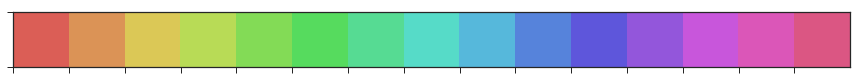

In [11]:
# Assign a consistent colorscheme:
rgb15 = sns.color_palette('hls', n_colors=15)
print(len(rgb15))
sns.palplot(rgb15)

#'Paired' is also good but only 12

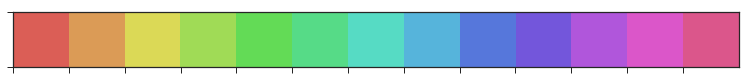

In [12]:
pal2 = sns.color_palette('hls', n_colors=13)
sns.palplot(pal2)

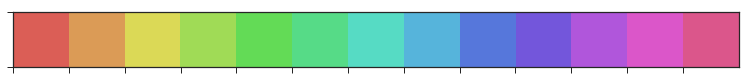

In [13]:
sns.palplot(pal2)

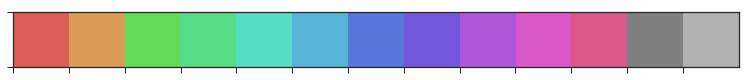

In [14]:
#drop the 2 lightest colors & use grey shades for controls

pal2 = pal2[0:2] + pal2[4:]
color_dict2 = dict(zip(main_mutants[2:], pal2))
color_dict2['WT'] = (0.5,0.5,0.5)
color_dict2['—'] = (0.7,0.7,0.7)

sns.palplot(color_dict2.values())

In [15]:
color_dict2

{'A639S': (0.45119999999999971, 0.33999999999999997, 0.85999999999999999),
 'D302G': (0.85999999999999999, 0.61119999999999997, 0.33999999999999997),
 'D611N': (0.33999999999999997, 0.46879999999999972, 0.85999999999999999),
 'F644L': (0.69120000000000026, 0.33999999999999997, 0.85999999999999999),
 'G47E': (0.85999999999999999, 0.37119999999999997, 0.33999999999999997),
 'G609R': (0.33999999999999997, 0.70879999999999954, 0.85999999999999999),
 'P528T': (0.38880000000000003, 0.85999999999999999, 0.33999999999999997),
 'Q607E': (0.33999999999999997, 0.85999999999999999, 0.77120000000000011),
 'T646N': (0.85999999999999999, 0.33999999999999997, 0.78879999999999928),
 'V647L': (0.85999999999999999, 0.33999999999999997, 0.54879999999999951),
 'WT': (0.5, 0.5, 0.5),
 'Δ528-530': (0.33999999999999997, 0.85999999999999999, 0.53120000000000012),
 '—': (0.7, 0.7, 0.7)}

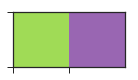

In [16]:
# squeezing a couple of extra colors for the supplementary. One was the light green removed from above

sns.palplot([(0.6287999999999998, 0.85999999999999999, 0.33999999999999997), (0.6, 0.4, 0.7)])

color_dict_supp = {'WT': (0.5, 0.5, 0.5),
'—': (0.7, 0.7, 0.7),
'I375V':(0.6287999999999998, 0.85999999999999999, 0.33999999999999997), 
'A643T':(0.6, 0.4, 0.7)}

# Bat plot & save functions

In [17]:
# Put all the plotting in one function

def save_fig(name, fig_object):
    d = date.today().strftime('%y%m%d')
    filename = d+name+'.pdf'
    plt.savefig(filename, transparent=True)
    pass

    
def sem_ordered(df, x, y, order):
    sem_df = df.groupby(x)[y].sem()
    sem_list = []
    for m in order:
        sem_list.append(sem_df[m])
    return sem_list

def means_ordered(df, x, y, order):
    mean_df = df.groupby(x)[y].mean()
    mean_list = []
    for m in order:
        mean_list.append(mean_df[m])
    return mean_list

def place_hlines(means, yerr, horizontal=2, order=main_mutants, colors=color_dict2):
    for n, mean in enumerate(means[0:horizontal]):
        c = color_dict2[order[n]]
        err_list = [(mean+yerr[n]), (mean-yerr[n])]
        plt.hlines(mean, -0.5, len(yerr), linestyles='solid', linewidth=0.4, zorder=0, color='grey', alpha=0.4)
        #plt.hlines(err_list, -0.5, len(yerr),linestyles='dashed', linewidth=0.4, zorder=0, color=c, alpha0.3)
        plt.fill_between(x=[-0.5, len(yerr)], y1=err_list[0], y2=err_list[1], color='grey', alpha=0.35)
        
    
    

def barplot_swarmplot_format(df, x, y, title, ylabel='Amplitude (nA)', fontsize=16, order=main_mutants, pal=color_dict2,
                            convert_pA=True, horizontal=2): 
    '''horizontal specifies the number of guides to plot, taking values from ordered mean and SEM lists'''
    
    if convert_pA & max(df[y] > 10): #changes the underlying df, so helpful to check if it was already converted
        df[y]=df[y]/1000
        
    yerr = sem_ordered(df=df, x=x, y=y, order=order)
    means = means_ordered (df=df, x=x, y=y, order=order)
    
    sns.barplot(x=df[x], y=df[y], ci=None, order=order, alpha=1, palette=pal, yerr=yerr,)
    sns.swarmplot(x=df[x], y=df[y], color='k', size=3.5, order=order)
    #plt.hlines(means[0:horizontal], 0, len(yerr), linestyles='dashed', linewidth=0.5, zorder=0)
    #plt.hlines(yerr[0:horizontal], 0, len(yerr), linestyles='dashed', linewidth=0.2) need to add and subtract from mean
    place_hlines(means, yerr, horizontal=horizontal)
    
    sns.set_style("ticks", {"axes.linewidth": 1})
    plt.xticks(range(len(order)), order, rotation=45, size=fontsize, ha='right')
    plt.xlabel('')
    plt.yticks(size=fontsize)
    plt.ylabel(ylabel, size=fontsize)
    sns.despine()
    plt.tight_layout()
    plt.title(title, size=fontsize)
    pass


# Figure 1: homomer amplitude

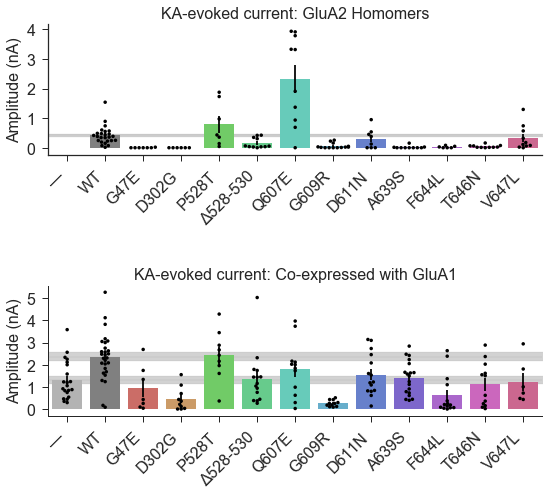

In [18]:
# make figure 1
fig = plt.figure(figsize=(8,7))
ax1 = plt.subplot(211)
barplot_swarmplot_format(df=hom_amp_df, x='Mutant', y='KA Amplitude', title='KA-evoked current: GluA2 Homomers')

ax2 = plt.subplot(212)
barplot_swarmplot_format(df=het_amp_df, x='Mutant', y='KA Amplitude', title='KA-evoked current: Co-expressed with GluA1')

plt.subplots_adjust(hspace=1)

save_fig('Amplitude_resub_', fig)

plt.show()

# figure S1: holding current

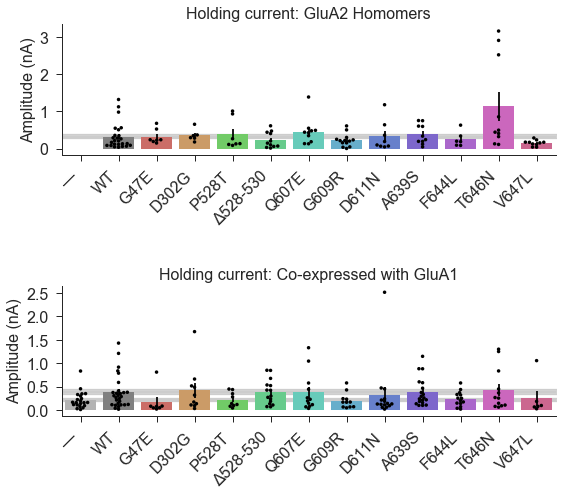

In [19]:
fig = plt.figure(figsize=(8,7))
ax1 = plt.subplot(211)
barplot_swarmplot_format(df=hom_amp_df, x='Mutant', y='KA Holding current', title='Holding current: GluA2 Homomers')

ax2 = plt.subplot(212)
barplot_swarmplot_format(df=het_amp_df, x='Mutant', y='KA Holding current', title='Holding current: Co-expressed with GluA1')

plt.subplots_adjust(hspace=1)

#plt.savefig('Amplitude_resub_March_Color.pdf', transparent=True)
save_fig('Holding_resub', fig)

plt.show()

# Figure 3a: plot ramps with appropriate colors

In [20]:
# Function for plotting each ramp
# Then function for plotting each of a list of ramps as a subplot

def graph_ramp(df, m, i, fig, col, sub):
    '''Makes the individual ramp plot for each mutant'''
    
    sns.set_style("ticks")
    ax = fig.add_subplot(4,4,sub) # bank of 16 subplots. May need to change this
    
    mV_ms = 180/1800   # gradient of the ramp protocol that was used in the recording
    x_ms = np.array(range(0,1800))
    x_mV = (x_ms*mV_ms)-104   #-100 because the ramp started at -100, then also -4 to correct for LJP

    plt.plot(x_mV[2:], df['mean'].iloc[1002:2800], color=col, lw=3)
    plt.plot(x_mV[2:], df['pos_error'].iloc[1002:2800], color=col, alpha = 0.8, lw=1)
    plt.plot(x_mV[2:], df['neg_error'].iloc[1002:2800], color=col, alpha = 0.8, lw=1)
    
    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_color('none')
    plt.xticks(np.arange(-70, 100, step=110), size=12)
    plt.yticks(np.arange(-2, 2.1, step=4), size=12)
    
    plt.axhline(0, color='black', alpha=1, lw=1)
    plt.axvline(0, color='black', alpha=1, lw=1)
    
    plt.xlabel('')
    plt.ylabel('')
    plt.title('     '+m, size=16)
    plt.ylim(-3.2, 2.500)
    pass


# dictionary defines which mutant goes to which subplot

subplots = dict(zip(main_mutants,list(range(1,len(main_mutants)+1))))

def plot_many_ramps(ramps_df, Mutant_list, figsize=(14,14), color_dict=color_dict2, subplots=subplots):
    fig = plt.figure(figsize=figsize)

    for i, m in enumerate(Mutant_list):
        title = m + ' subtracted ramps'
        df_to_plot = pd.DataFrame()
        file_list = ramps_df['File'][ramps_df['Mutant'] == m]
        for f in file_list:
            name = f + ".EDRRampSummary.csv"
            df = pd.read_csv(name)
            df_to_plot[f] = df['Subtracted']

        if m == 'GRIA1':
            label = '—'
        elif m == '528Del':
            label = 'P528-530Del'
        else:
            label = m

        data_col = df_to_plot.columns
        df_to_plot['mean'] = df_to_plot.aggregate('mean', axis=1)/1000 #convert from pA to nA
        df_to_plot['SEM'] = df_to_plot[data_col].aggregate('sem', axis=1)/1000
        df_to_plot['pos_error'] = df_to_plot['mean']+df_to_plot['SEM']
        df_to_plot['neg_error'] = df_to_plot['mean']-df_to_plot['SEM']

        color = color_dict[label]

        graph_ramp(df_to_plot, label, i, fig, col=color, sub=subplots[m])

    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
    return fig


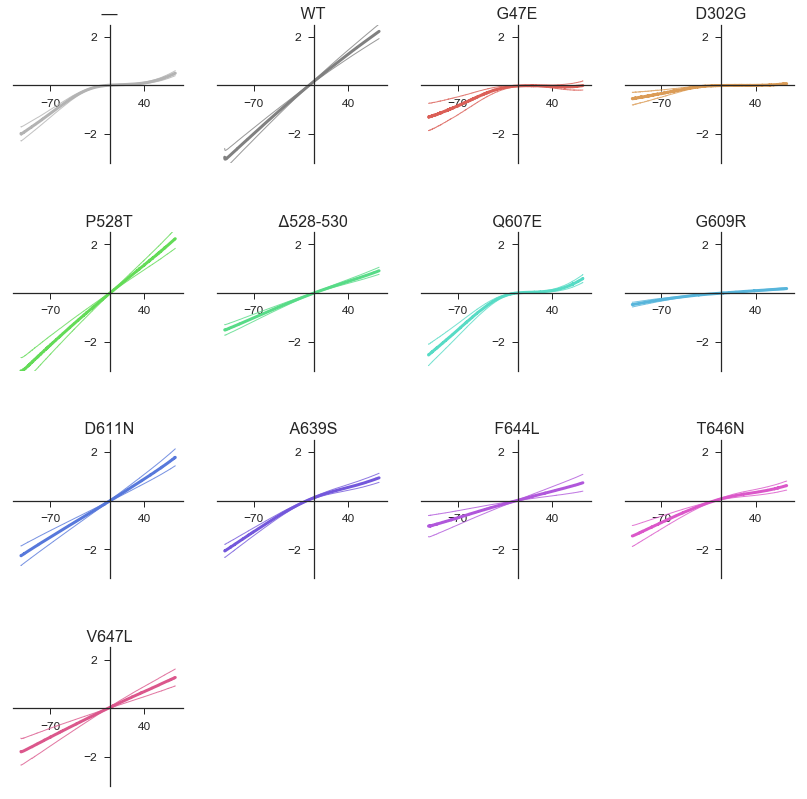

In [21]:
fig = plot_many_ramps(het_ramps_df, main_mutants)
save_fig('13ramps', fig)

In [22]:
### refactoring badly needed here!!!


def plot_single_ramp (ramps_df, Mutant, color_dict=color_dict2):
    
    df_to_plot = pd.DataFrame()
    file_list = ramps_df['File'][ramps_df['Mutant'] == Mutant]
    for f in file_list:
        name = f + ".EDRRampSummary.csv"
        df = pd.read_csv(name)
        df_to_plot[f] = df['Subtracted']
    
    
    
    
    data_col = df_to_plot.columns
    df_to_plot['mean'] = df_to_plot.aggregate('mean', axis=1)/1000 #convert from pA to nA
    df_to_plot['SEM'] = df_to_plot[data_col].aggregate('sem', axis=1)/1000
    df_to_plot['pos_error'] = df_to_plot['mean']+df_to_plot['SEM']
    df_to_plot['neg_error'] = df_to_plot['mean']-df_to_plot['SEM']

    color = color_dict[Mutant]

    sns.set_style("ticks")
    
    mV_ms = 180/1800   # gradient of the ramp protocol that was used in the recording
    x_ms = np.array(range(0,1800))
    x_mV = (x_ms*mV_ms)-104   #-100 because the ramp started at -100, then also -4 to correct for LJP

    plt.plot(x_mV[2:], df_to_plot['mean'].iloc[1002:2800], color=color, lw=3)
    plt.plot(x_mV[2:], df_to_plot['pos_error'].iloc[1002:2800], color=color, alpha = 0.8, lw=1)
    plt.plot(x_mV[2:], df_to_plot['neg_error'].iloc[1002:2800], color=color, alpha = 0.8, lw=1)
    
    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_color('none')
    plt.xticks(np.arange(-70, 100, step=110), size=12)
    plt.yticks(np.arange(-2, 2.1, step=4), size=12)
    
    plt.axhline(0, color='black', alpha=1, lw=1)
    plt.axvline(0, color='black', alpha=1, lw=1)
    
    plt.xlabel('')
    plt.ylabel('')
    plt.title('     '+m, size=16)
    plt.ylim(-3.2, 2.500)
    pass

# figure S1: Other mutants

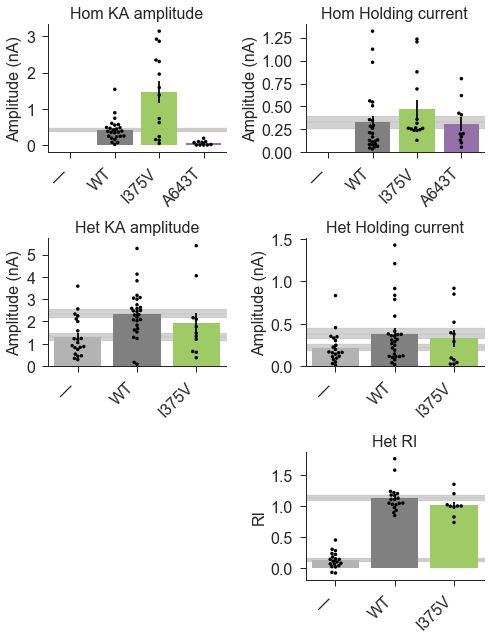

In [24]:
# supp mutants were excluded from the main figures

fig = plt.figure(figsize=(7,9))
ax1 = plt.subplot(321)
barplot_swarmplot_format(df=hom_amp_df, x='Mutant', y='KA Amplitude', title='Hom KA amplitude', order=supp_mutants,
                pal=color_dict_supp)

ax2 = plt.subplot(322)
barplot_swarmplot_format(df=hom_amp_df, x='Mutant', y='KA Holding current', title='Hom Holding current', order=supp_mutants,
                pal=color_dict_supp)

ax3 = plt.subplot(323)
barplot_swarmplot_format(df=het_amp_df, x='Mutant', y='KA Amplitude', title='Het KA amplitude', 
                         order=['—', 'WT', 'I375V'], pal=color_dict_supp)

ax4 = plt.subplot(324)
barplot_swarmplot_format(df=het_amp_df, x='Mutant', y='KA Holding current', title='Het Holding current', 
                         order=['—', 'WT', 'I375V'], pal=color_dict_supp)

# insert the ramp plot by hand

ax6 = plt.subplot(326)
barplot_swarmplot_format(df=het_ramps_df, x='Mutant', y='RI_transform', title='Het RI', 
                         order=['—', 'WT', 'I375V'], pal=color_dict_supp, ylabel='RI')

save_fig('Leftover_mutants', fig)

# Figure 3b: with ramps, summarise RI

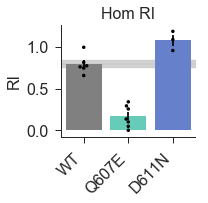

In [33]:
fig = plt.figure(figsize=(5,7))
ax1 = plt.subplot(321)
barplot_swarmplot_format(df=hom_ramps_df, x='Mutant', y='RI_transform', title='Hom RI', 
                         order=['WT', 'Q607E', 'D611N'], pal=color_dict2, ylabel='RI', horizontal=1)

save_fig('HomRamps', fig)

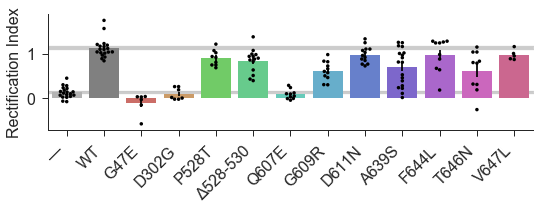

In [35]:
# current at +40 as a percent of -70, normalised to WT

# How do we put this into the previous figure?

fig = plt.figure(figsize=(8,3))

barplot_swarmplot_format(df=het_ramps_df, x='Mutant', y='RI_transform', title=' ', 
                         convert_pA=False, ylabel='Rectification Index')

save_fig('ramps_resub', fig)

plt.show()

# Figure 5: Plot the RI against the amplitude

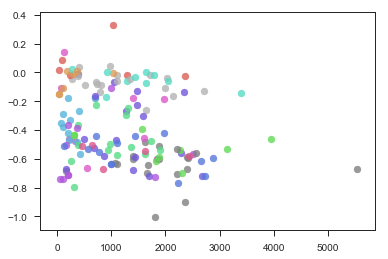

In [36]:
##Plotting indivudual cells shows little correlation between RI and amplitude

for row in range(len(het_ramps_df)):
    data = het_ramps_df.iloc[row]
    x = data['-70mV I']*-1
    y = data['RI']
    m = data['Mutant']

    if m in color_dict2.keys():
        c = color_dict2[m]
        plt.scatter(x,y,color=c,alpha=0.8)


plt.show()

In [38]:
# Change this to use actual amplitude measurement
# Change to adjusted RI
# Map to a color

ramps_paper = het_ramps_df[het_ramps_df['Mutant'].isin(main_mutants)]
scatter_RI= ramps_paper.groupby('Mutant')['RI_transform'].agg([ 'mean','sem',])
het_paper = het_amp_df[het_amp_df['Mutant'].isin(main_mutants)]
scatter_amp = het_paper.groupby('Mutant')['KA Amplitude'].agg(['mean','sem', ])

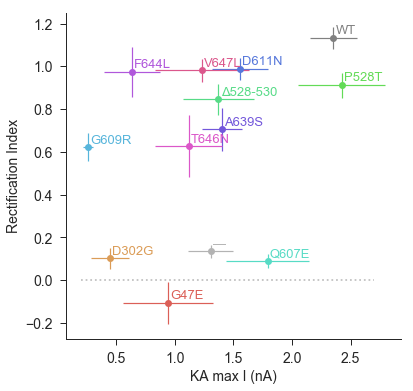

In [39]:


fig = plt.figure(figsize=(6,6))

#plt.scatter(x=scatter_amp['mean'], y=scatter_RI['mean'])

plt.xlabel('KA max I (nA)', fontsize=14)
plt.ylabel('Rectification Index', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.errorbar(x=DK_scatter['-70mV I']*-1, y=DK_scatter['RI'], xerr=DK_error['-70mV I'], 
             #yerr=DK_error['RI'], fmt='o', alpha=1)

#add tags
for row in range(len(scatter_amp)):
    label = scatter_amp.index[row]
    color = color_dict2[label]
    x = scatter_amp.loc[label, 'mean'] # the mean amplitude values
    y = scatter_RI.loc[label, 'mean'] # the RI values
    x_err = scatter_amp.loc[label, 'sem']
    y_err = scatter_RI.loc[label, 'sem']
    plt.text(x+0.02,y+0.02,label, fontsize=13, color=color, horizontalalignment='left')
    plt.errorbar(x=x, y=y, xerr=x_err, 
             yerr=y_err, fmt='o', alpha=1, ecolor=color, c=color, elinewidth=1.2)

plt.hlines(0, 0.2, 2.7, linestyles='dotted', color='grey', alpha=0.5)
#plt.vlines(0, 0, 1.2, linestyles='dotted', color='grey', alpha=0.3)
    
sns.despine()
save_fig('MaxI_vsRI', fig)


In [ ]:
#Take the 2 columns we need to graph
Amp = df[['Mutant', 'KA Amplitude']]
Hold = df[['Mutant', 'KA Holding current']]

In [ ]:
AmpG = Amp.groupby('Mutant')
HoldG = Hold.groupby('Mutant')

In [ ]:
A = AmpG.agg(['mean', 'sem'])
H = HoldG.agg(['mean', 'sem', 'count'])
summary = pd.concat([A,H], axis=1).round(0)
#concatenate the 2 df, matching the axis(??) then remove the decimals with round

# Functions for stats: compare everything to WT with t-test

#Tuple that gives the df, the column to extract and the name of the data
export_df_info = ((hom_amp_df,'KA Amplitude','homomer_KAamp'),
                  (het_amp_df,'KA Amplitude','heteromer_KAamp'),
                  (hom_amp_df, 'KA Holding current', 'hom_holding'),
                  (het_amp_df, 'KA Holding current', 'het_holding'),
                  (hom_ramps_df, 'RI_transform', 'homomer_ramps',),
                  (het_ramps_df, 'RI_transform', 'heteromer_ramps',))

In [50]:
# Calculate t-test p-values
WT_hom_amp_df = hom_amp_df[hom_amp_df['Mutant'] == 'WT']

# the number unpacks the p-value from the returned tuple
rawP_gluR1 = hom_amp_df.groupby('Mutant')['KA Amplitude'].apply(lambda x: stats.ttest_ind(x, hom_amp_df['KA Amplitude'], 
                                                                              equal_var=False)[1])

WT_hom_amp_df

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3126: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)


,Date,Mutant,Record,KA Holding current,KA Amplitude,CTZ Holding current,CTZ Amplitude,Glu Holding current,Glu Amplitude,KA Holding current.1,KA Amplitude.1,rawP
1,171206.0,WT,002,0.548700,0.444300,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,171212.0,WT,002,0.168450,0.343292,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,171213.0,WT,002,0.356150,0.891850,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,171213.0,WT,004,0.131237,0.249715,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,171221.0,WT,001,0.120233,0.550433,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,171222.0,WT,004,0.059233,0.244350,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,171222.0,WT,006,0.047833,0.190100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,171222.0,WT,007,0.066533,0.486480,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,171222.0,WT,009,0.215033,0.380305,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,180130.0,WT,002,0.292360,0.476988,355.225,414.125000,272.216667,184.631667,221.692222,137.356667,NaN


In [69]:
hom_amp_df.groupby('Mutant')['KA Amplitude'].apply(lambda x: stats.ttest_ind(x, WT_hom_amp_df['KA Amplitude'], 
                                                                              equal_var=False, nan_policy='omit')[1], )

Mutant
A639S       1.33962e-06
A643T       5.86879e-06
D302G       6.50971e-07
D611N          0.424265
F644L       1.77993e-06
G47E        7.15146e-07
G609R       8.90735e-06
G745V          0.225453
G778A         0.0159158
I375V        0.00478126
P528T          0.240417
Q607E        0.00307447
T646N       3.67027e-06
V647L          0.589332
V830M       4.56891e-05
W788L          0.555648
WT                    1
Δ528-530     0.00335679
—                    --
Name: KA Amplitude, dtype: object

In [240]:
def assign_stars(p):
    if p > 0.05:
        return 'ns'
    elif p > 0.01:
        return '*'
    elif p > 0.001:
        return '**'
    elif p <= 0.001:
        return '***'
    else:
        return ''


def make_stats_df(df, column_to_extract, list_of_mutants, compare='WT'):
    WT_df = df[df['Mutant'] == compare]
    test_df = df[df['Mutant'].isin(list_of_mutants)]
    stats_df = pd.DataFrame()
    stats_df['welch_p'] = test_df.groupby('Mutant')[column_to_extract].apply(lambda x: stats.ttest_ind(x, WT_df[column_to_extract], 
                                                                              equal_var=False, nan_policy='omit')[1])

    stats_df['welch_sig'] = stats_df['welch_p'].apply(lambda x: assign_stars(x))
    stats_df['bonferroni_p'] = multipletests(stats_df['welch_p'], method='bonferroni')[1]
    stats_df['bon_sig'] = stats_df['bonferroni_p'].apply(lambda x: assign_stars(x))
    
    stats_df['holm_p'] = multipletests(stats_df['welch_p'], method='holm')[1]
    stats_df['holm_sig'] = stats_df['holm_p'].apply(lambda x: assign_stars(x))
    
    return(stats_df)


def sort_df(df, sort_list):
    '''Re-organises data frame to new order, including only the mutants on the sort list.
    Allows mutants not on the graph to be removed, but still part of the statistical analysis.
    Test case to assert that longer sort list doesn't cause error:
    sort_df(test, ['WT', 'Q607E', 'Blank'])'''
    res = pd.DataFrame(columns=df.columns)
    for m in sort_list:
        if m in df.index: # stops error when the sort list has more mutants than the table
            line = df.loc[m]
            res = res.append(line)

    return res
     

In [241]:
# Tuple must include: df, analysis column, name of table, comparison

export_stats_info = ((hom_amp_df,'KA Amplitude','homomer_KAamp_vsWT', 'WT'),
                  (het_amp_df,'KA Amplitude','coexp_KAamp_vsWT', 'WT'),
                    (het_amp_df,'KA Amplitude','coexp_KAamp_vsNeg', '—'),
                
                  (hom_amp_df, 'KA Holding current', 'hom_holding_vsWT', 'WT'),
                  (het_amp_df, 'KA Holding current', 'coexp_holding_vsWT', 'WT'),
                     (het_amp_df, 'KA Holding current', 'coexp_holding_vsNeg', '—'),
                  (hom_ramps_df, 'RI_transform', 'homomer_ramps_vsWT', 'WT'),
                  (het_ramps_df, 'RI_transform', 'coexp_ramps_vsWT', 'WT'),
                     (het_ramps_df, 'RI_transform', 'coexp_ramps_vsNeg', '—')
                    )

In [242]:
# Do the stats for all the tables, then dump them into an excel
# (hom_amp_df,'KA Amplitude','homomer_KAamp')
# export_df_info

def sorted_stats(info_tuple, sort_list):
    '''Pass a single info tuple.
    for each df, makes a nice dataframe with the set of stats'''
    df = info_tuple[0]
    column_to_extract = info_tuple[1]
    name = info_tuple[2]
    compare = info_tuple[3]
    stats_df = make_stats_df(df, column_to_extract, sort_list, compare)
    nice_stats = sort_df(stats_df, sort_list)
    return nice_stats

def full_stats_export(info_tuple_list, project,  sort_list):
    '''works through the list to make stats,
    Exports all of these into different sheets in excel'''
    file = make_excel(project)
    for line in info_tuple_list:
        df = sorted_stats(line, sort_list=sort_list)
        name = line[2]
        df.to_excel(file, sheet_name=name, index=True)
    file.save()


In [243]:
full_stats_export(info_tuple_list=export_stats_info, project='ephys_stats', sort_list=all_mutants)